# Time Series Analysis using Python

# [**Dataset Link**](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data)

In [108]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.9 MB/s eta 0:00:00


In [109]:
import numpy as np
import pandas as pd
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize']=10,6

In [73]:
data = pd.read_csv("/content/drive/MyDrive/Dataset/Time_Series/DailyDelhiClimateTrain.csv")
print(data.describe(),'\n\n',data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
          meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333 

 None


### Parse strings to datatime type

In [74]:
data = data[['date','meantemp']]

data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)
indexedDataset = data.set_index(['date'])

<ipython-input-74-4e88d0768998>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)


In [75]:
data

,date,meantemp
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000
...,...,...
1457,2016-12-28,17.217391
1458,2016-12-29,15.238095
1459,2016-12-30,14.095238
1460,2016-12-31,15.052632


### Plot Sample Graph

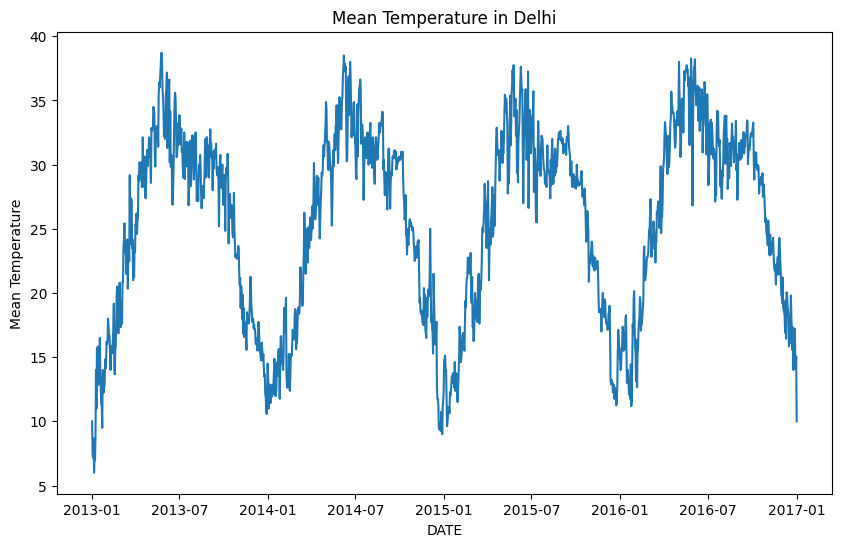

In [76]:
plt.title("Mean Temperature in Delhi")
plt.xlabel("DATE")
plt.ylabel("Mean Temperature")
plt.plot(indexedDataset)

### Checking stationarity of raw data

* Using Rolling Statistics




In [77]:
rollmean = indexedDataset.rolling(window=12).mean()
rollstd = indexedDataset.rolling(window=12).std()
print(rollmean, rollstd)

             meantemp
date                 
2013-01-01        NaN
2013-01-02        NaN
2013-01-03        NaN
2013-01-04        NaN
2013-01-05        NaN
...               ...
2016-12-28  17.054552
2016-12-29  16.866060
2016-12-30  16.700385
2016-12-31  16.466676
2017-01-01  15.650009

[1462 rows x 1 columns]             meantemp
date                
2013-01-01       NaN
2013-01-02       NaN
2013-01-03       NaN
2013-01-04       NaN
2013-01-05       NaN
...              ...
2016-12-28  1.417658
2016-12-29  1.500971
2016-12-30  1.692697
2016-12-31  1.711964
2017-01-01  2.234899

[1462 rows x 1 columns]


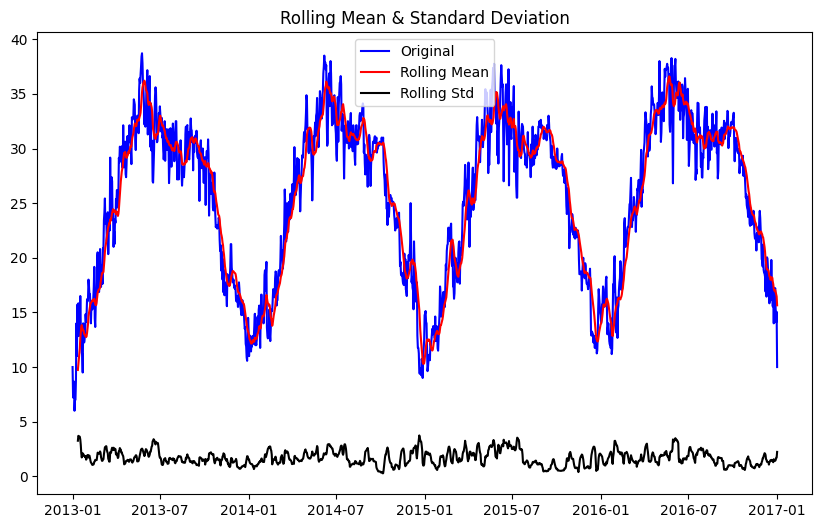

In [78]:
orig = plt.plot(indexedDataset, color = 'blue', label = "Original")
mean = plt.plot(rollmean, color = 'red', label = "Rolling Mean")
std = plt.plot(rollstd, color = 'black', label = "Rolling Std")
plt.legend(loc = "best")
plt.title("Rolling Mean & Standard Deviation")
plt.show()

*  Using Augmented Dicky-Fuller (ADF) Test



In [79]:
print("Results of Dickey Fuller Test:")
dftest = adfuller(indexedDataset['meantemp'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4],index=['Test statistic','p-value','#Lags used','No. of observations used'])
for key, value in dftest[4].items():
  dfoutput['Critical value (%s)'%key]= value

print(dfoutput)

Results of Dickey Fuller Test:
Test statistic                -2.021069
p-value                        0.277412
#Lags used                    10.000000
No. of observations used    1451.000000
Critical value (1%)           -3.434865
Critical value (5%)           -2.863534
Critical value (10%)          -2.567832
dtype: float64


In [80]:
def test_stationarity(timeSeries):
  movingaverage = timeSeries.rolling(window=12).mean()
  movingSTD = timeSeries.rolling(window=12).std()

  orig = plt.plot(timeSeries, color = 'blue', label = "Original")
  mean = plt.plot(movingaverage, color = 'red', label = "Rolling Mean")
  std = plt.plot(movingSTD, color = 'black', label = "Rolling Std")
  plt.legend(loc = "best")
  plt.title("Rolling Mean & Standard Deviation")
  plt.show()

  print("Results of Dickey Fuller Test:")
  dftest = adfuller(timeSeries['meantemp'], autolag='AIC')
  dfoutput = pd.Series(dftest[0:4],index=['Test statistic','p-value','#Lags used','No. of observations used'])
  for key, value in dftest[4].items():
    dfoutput['Critical value (%s)'%key]= value
  print(dfoutput)

### Subtracting Moving Average from LogScale Data

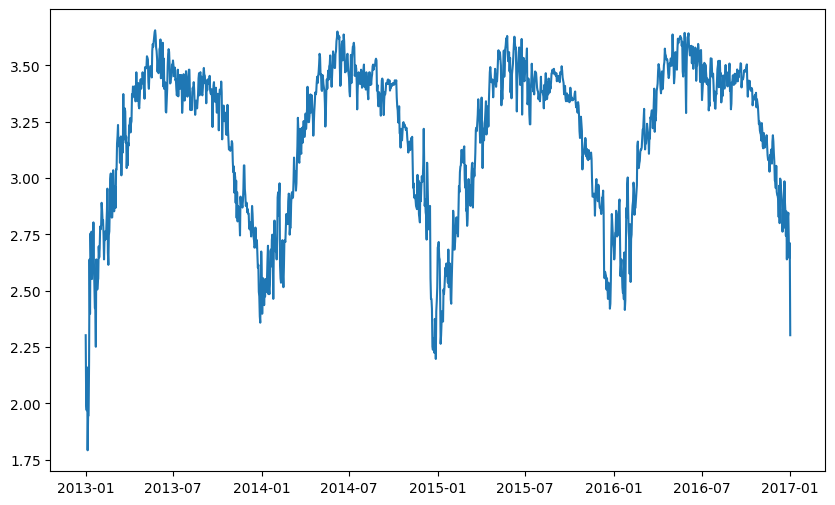

In [81]:
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

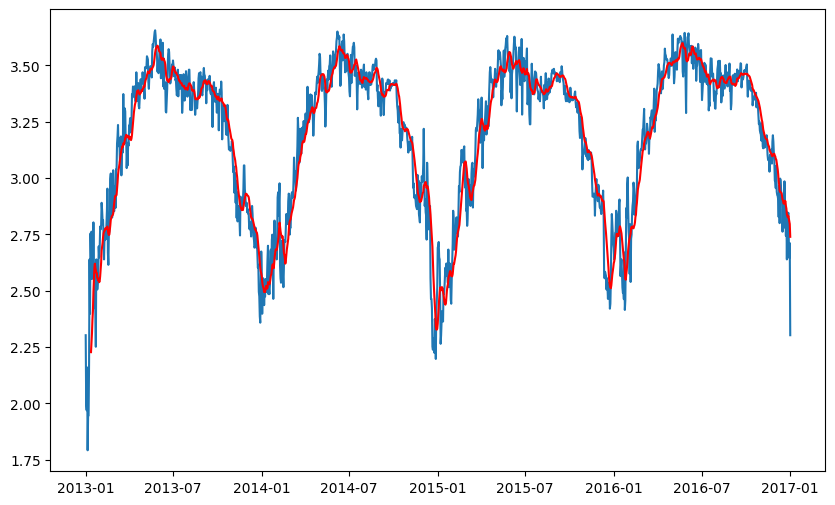

In [82]:
movingaverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingaverage, color='red')

In [83]:
dataLogScaleMinusMovingAverage = indexedDataset_logScale - movingaverage
dataLogScaleMinusMovingAverage

,meantemp
date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,NaN
2013-01-04,NaN
2013-01-05,NaN
...,...
2016-12-28,0.012768
2016-12-29,-0.097820
2016-12-30,-0.164786


In [84]:
dataLogScaleMinusMovingAverage.dropna(inplace=True)
dataLogScaleMinusMovingAverage

,meantemp
date,
2013-01-12,0.411693
2013-01-13,0.496459
2013-01-14,0.240507
2013-01-15,0.317331
2013-01-16,0.216627
...,...
2016-12-28,0.012768
2016-12-29,-0.097820
2016-12-30,-0.164786


### Test Stationarity

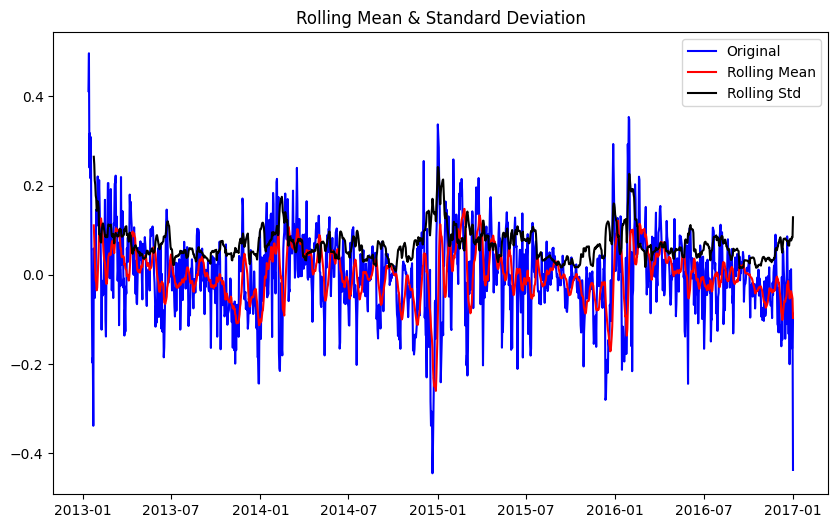

Results of Dickey Fuller Test:
Test statistic             -8.828078e+00
p-value                     1.800719e-14
#Lags used                  1.100000e+01
No. of observations used    1.439000e+03
Critical value (1%)        -3.434902e+00
Critical value (5%)        -2.863551e+00
Critical value (10%)       -2.567840e+00
dtype: float64


In [85]:
test_stationarity(dataLogScaleMinusMovingAverage)

### Subtrating Exponential Decay Weighted Average from LogScale Data

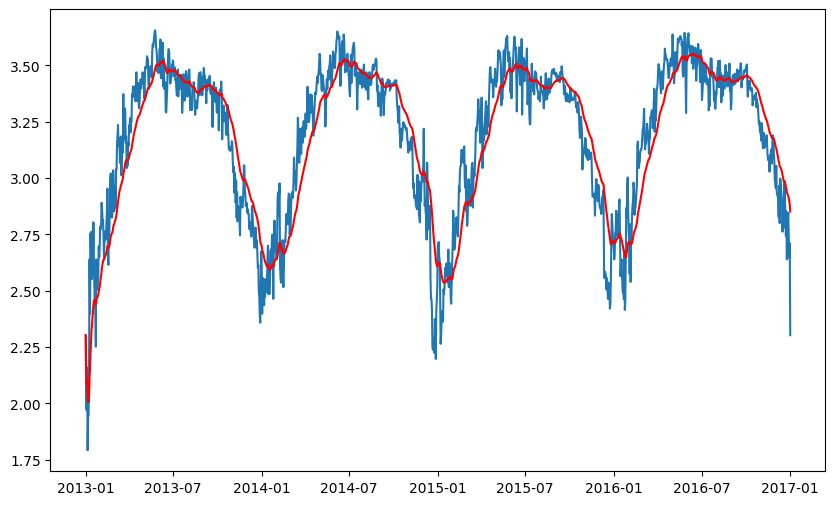

In [86]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12,min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage,color='red')

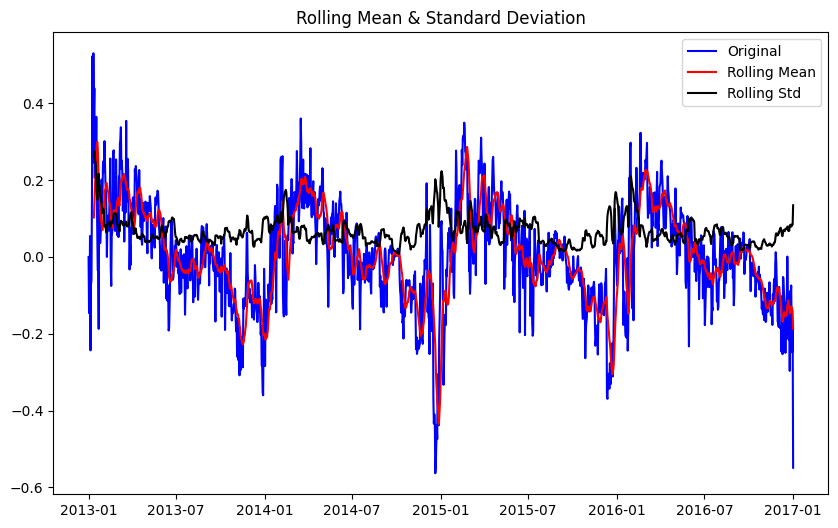

Results of Dickey Fuller Test:
Test statistic                -3.913459
p-value                        0.001938
#Lags used                    13.000000
No. of observations used    1448.000000
Critical value (1%)           -3.434874
Critical value (5%)           -2.863538
Critical value (10%)          -2.567834
dtype: float64


In [87]:
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

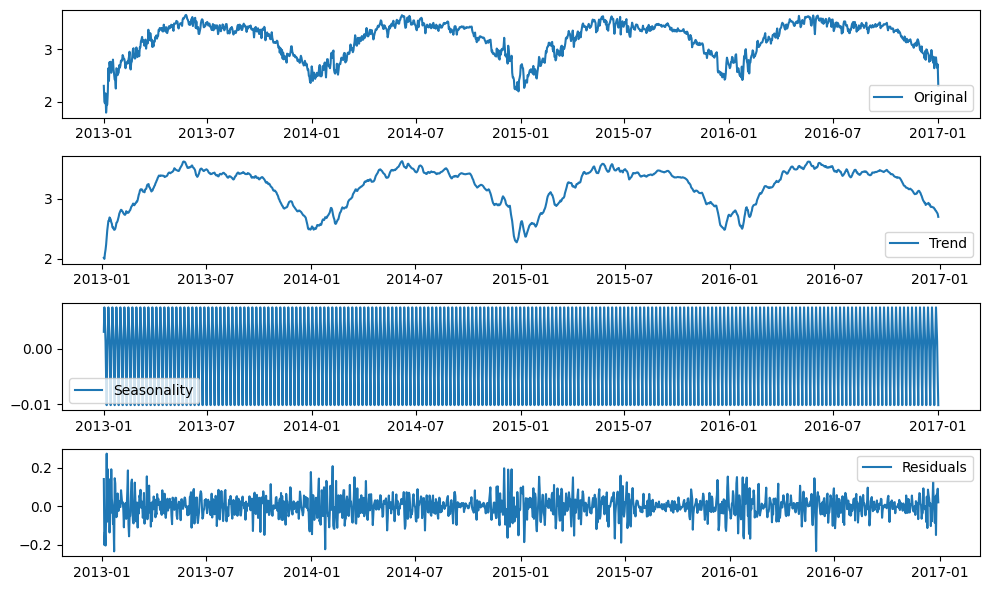

In [88]:
decomposition = seasonal_decompose(indexedDataset_logScale)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(indexedDataset_logScale, label = 'Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [89]:
decomposedLogData = residual
decomposedLogData.dropna(inplace = True)
print(decomposedLogData)

date
2013-01-04    0.141612
2013-01-05   -0.202442
2013-01-06   -0.134368
2013-01-07   -0.205260
2013-01-08   -0.058381
                ...   
2016-12-25   -0.150338
2016-12-26    0.060514
2016-12-27    0.053892
2016-12-28    0.091120
2016-12-29    0.020317
Name: resid, Length: 1456, dtype: float64


## AutoRegression Model

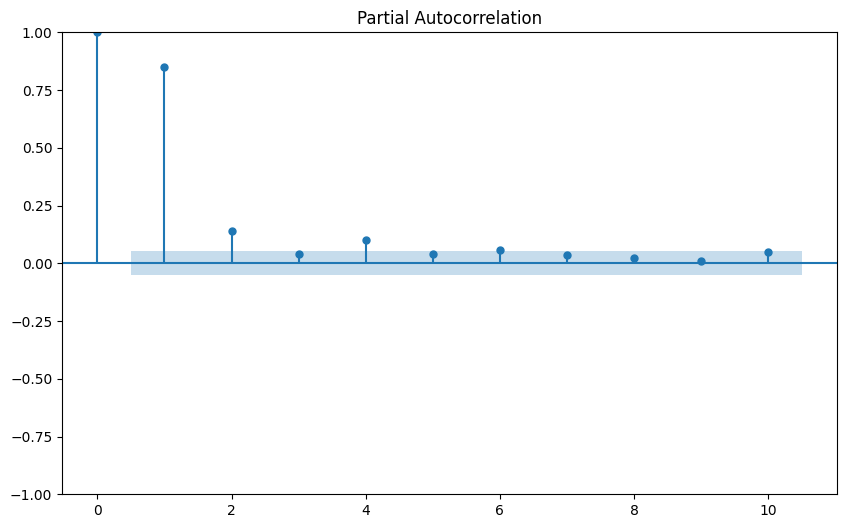

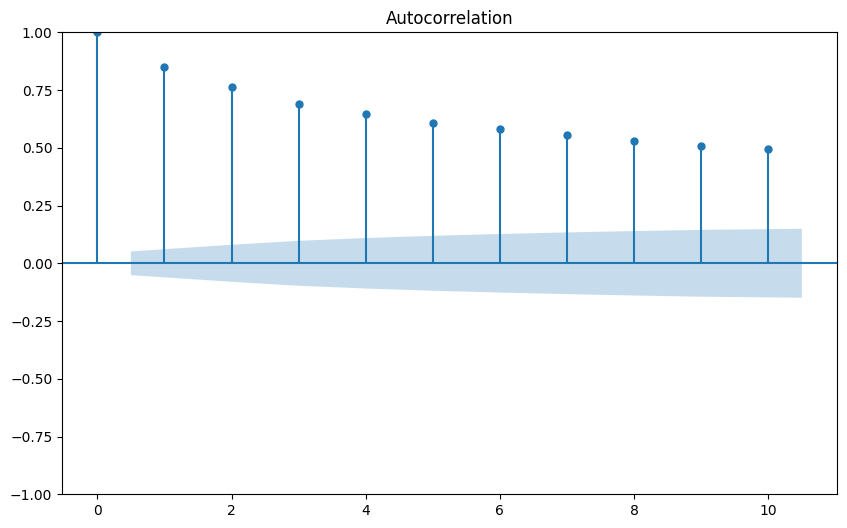

In [90]:
pacf=plot_pacf(datasetLogScaleMinusMovingExponentialDecayAverage,lags=10)
acf=plot_acf(datasetLogScaleMinusMovingExponentialDecayAverage,lags=10)

### Training and Testing Model

In [91]:
train=datasetLogScaleMinusMovingExponentialDecayAverage[:len(datasetLogScaleMinusMovingExponentialDecayAverage)-60]
test=datasetLogScaleMinusMovingExponentialDecayAverage[len(datasetLogScaleMinusMovingExponentialDecayAverage)-60:]

In [92]:
model_1 = AutoReg(train, lags=1).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [93]:
print("Model 1: ",model_1.summary())

Model 1:                              AutoReg Model Results                             
Dep. Variable:               meantemp   No. Observations:                 1402
Model:                     AutoReg(1)   Log Likelihood                1768.486
Method:               Conditional MLE   S.D. of innovations              0.068
Date:                Thu, 04 Apr 2024   AIC                          -3530.972
Time:                        08:08:14   BIC                          -3515.237
Sample:                    01-02-2013   HQIC                         -3525.090
                         - 11-02-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0016      0.002      0.884      0.376      -0.002       0.005
meantemp.L1     0.8570      0.014     62.087      0.000       0.830       0.884
                                    Ro

In [94]:
model_2 = AutoReg(train, lags=10).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [95]:
print("Model 2: ",model_2.summary())

Model 2:                              AutoReg Model Results                             
Dep. Variable:               meantemp   No. Observations:                 1402
Model:                    AutoReg(10)   Log Likelihood                1821.435
Method:               Conditional MLE   S.D. of innovations              0.065
Date:                Thu, 04 Apr 2024   AIC                          -3618.869
Time:                        08:08:14   BIC                          -3556.007
Sample:                    01-11-2013   HQIC                         -3595.363
                         - 11-02-2016                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0006      0.002      0.353      0.724      -0.003       0.004
meantemp.L1      0.7582      0.027     28.411      0.000       0.706       0.811
meantemp.L2      0.0467      0.033

In [96]:
pred_1 = model_1.predict(start=len(train),end=len(datasetLogScaleMinusMovingExponentialDecayAverage)-1, dynamic=False)
pred_2 = model_2.predict(start=len(train),end=len(datasetLogScaleMinusMovingExponentialDecayAverage)-1, dynamic=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


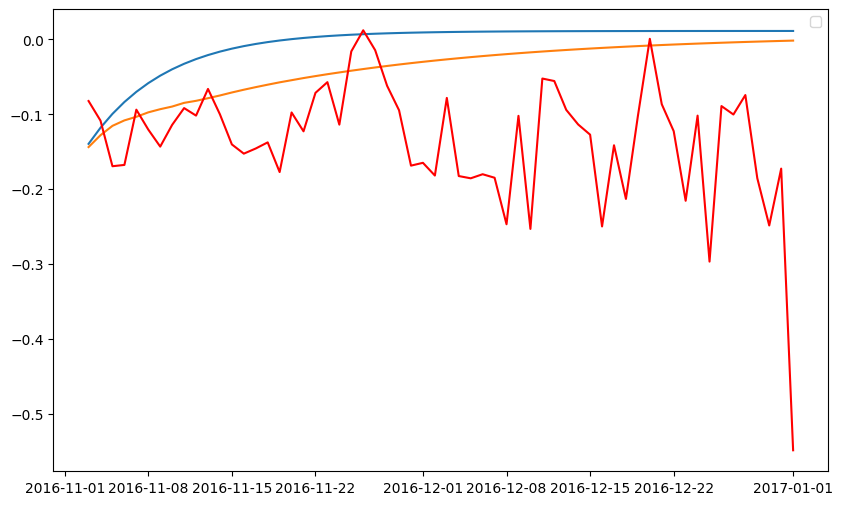

In [97]:
plt.plot(pred_1)
plt.plot(pred_2)
plt.legend()
plt.plot(test, color='red')

In [98]:
rmse=sqrt(mean_squared_error(test,pred))
print(rmse)

0.15851855964841244


## ARIMA Model

* ARIMA Model has 3 parameters
  - p : autoregressive lags
  - d : order of differnetiation (# times a time series is differentiated)
  - q : moving average

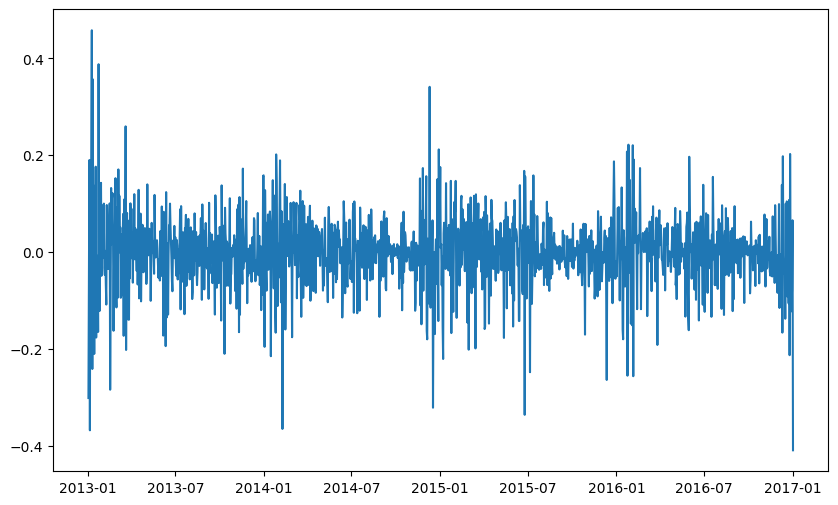

In [99]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

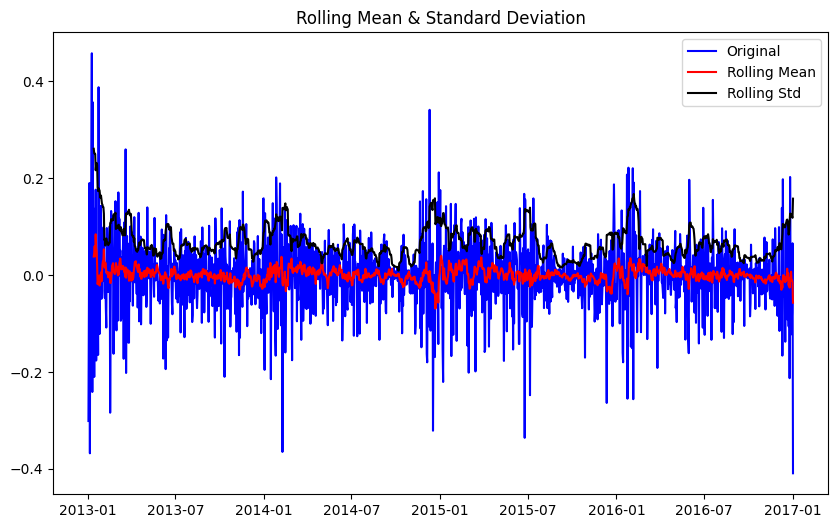

Results of Dickey Fuller Test:
Test statistic               -20.887532
p-value                        0.000000
#Lags used                     4.000000
No. of observations used    1456.000000
Critical value (1%)           -3.434849
Critical value (5%)           -2.863527
Critical value (10%)          -2.567828
dtype: float64


In [100]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

* Rolling Mean, Output is quite flat.
* Null Hypothesis / ADF is rejected as the time series is stationary.
* There is no trend


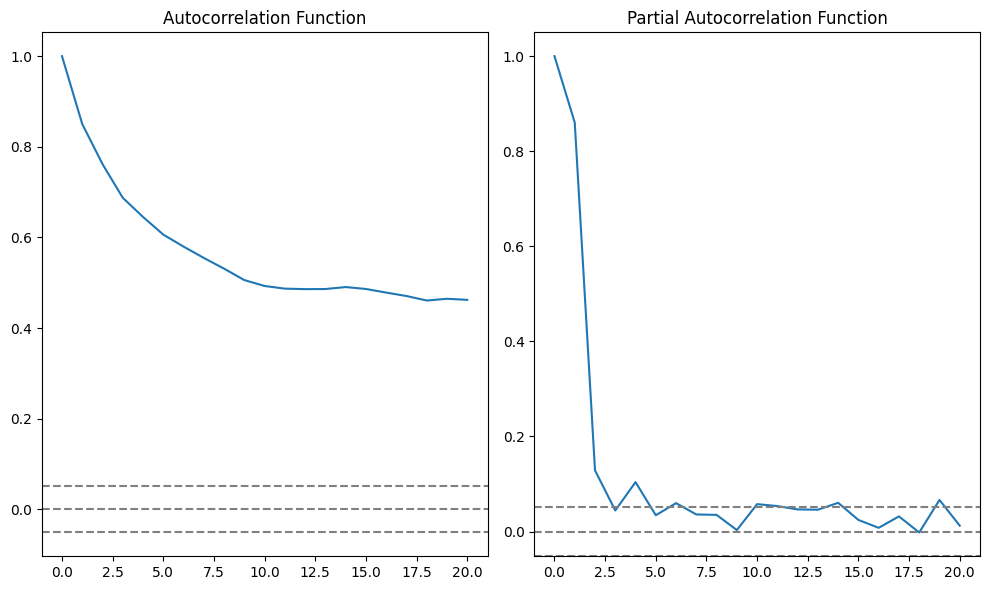

In [104]:
lag_acf = acf(datasetLogScaleMinusMovingExponentialDecayAverage, nlags=20)
lag_pacf = pacf(datasetLogScaleMinusMovingExponentialDecayAverage,nlags=20, method='ols')

#Plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--',color='grey')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogScaleMinusMovingExponentialDecayAverage)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogScaleMinusMovingExponentialDecayAverage)), linestyle='--', color='gray')
plt.title("Autocorrelation Function")

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--',color='grey')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogScaleMinusMovingExponentialDecayAverage)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogScaleMinusMovingExponentialDecayAverage)), linestyle='--', color='gray')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

### AR Model using ARIMA package

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


date
2013-01-01    0.003070
2013-01-02    0.000430
2013-01-03   -0.109151
2013-01-04   -0.104899
2013-01-05    0.026222
                ...   
2016-12-28   -0.086229
2016-12-29   -0.068214
2016-12-30   -0.148088
2016-12-31   -0.209742
2017-01-01   -0.160971
Length: 1462, dtype: float64
RSS: 6.952462
Plotting AR Model


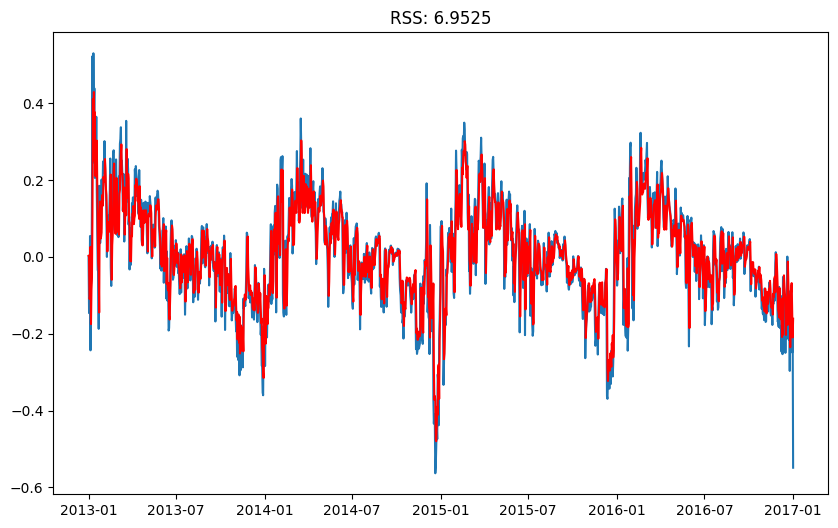

In [105]:
model_0 = ARIMA(datasetLogScaleMinusMovingExponentialDecayAverage, order=(2,0,0))
results_AR = model_0.fit()
print(results_AR.fittedvalues)
print('RSS: %f' % sum((results_AR.fittedvalues-datasetLogScaleMinusMovingExponentialDecayAverage['meantemp'])**2))
plt.plot(datasetLogScaleMinusMovingExponentialDecayAverage)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_AR.fittedvalues-datasetLogScaleMinusMovingExponentialDecayAverage['meantemp'])**2))
print("Plotting AR Model")

### MA Model using ARIMA package

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


date
2013-01-01    0.005726
2013-01-02    0.002083
2013-01-03   -0.113423
2013-01-04   -0.059985
2013-01-05    0.094923
                ...   
2016-12-28    0.001251
2016-12-29   -0.089407
2016-12-30   -0.108889
2016-12-31   -0.154255
2017-01-01   -0.077314
Length: 1462, dtype: float64
RSS: 9.950906
Plotting Ma Model


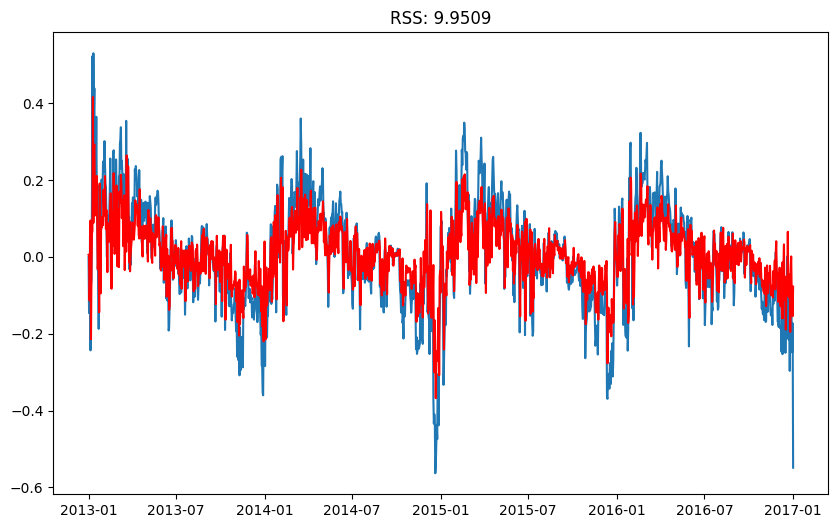

In [106]:
model_02 = ARIMA(datasetLogScaleMinusMovingExponentialDecayAverage, order=(0,0,2))
results_MA = model_02.fit()
print(results_MA.fittedvalues)
print('RSS: %f' % sum((results_MA.fittedvalues-datasetLogScaleMinusMovingExponentialDecayAverage['meantemp'])**2))
plt.plot(datasetLogScaleMinusMovingExponentialDecayAverage)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_MA.fittedvalues-datasetLogScaleMinusMovingExponentialDecayAverage['meantemp'])**2))
print("Plotting Ma Model")

### ARMA Model using ARIMA package

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


date
2013-01-01   -0.003172
2013-01-02   -0.000467
2013-01-03   -0.109363
2013-01-04   -0.095890
2013-01-05    0.027734
                ...   
2016-12-28   -0.101600
2016-12-29   -0.082472
2016-12-30   -0.159449
2016-12-31   -0.210190
2017-01-01   -0.160994
Length: 1462, dtype: float64
RSS: 6.758377
Plotting ARIMA Model


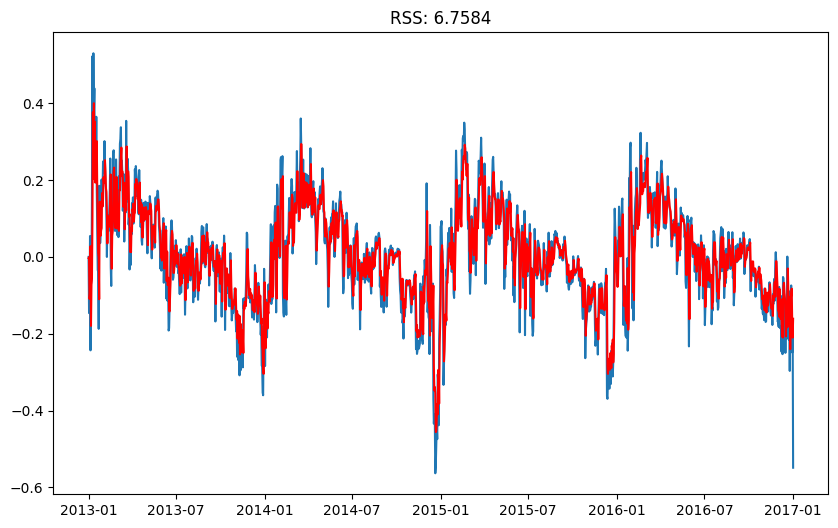

In [107]:
model_03 = ARIMA(datasetLogScaleMinusMovingExponentialDecayAverage, order=(2,0,2))
results_ARMA = model_03.fit()
print(results_ARMA.fittedvalues)
print('RSS: %f' % sum((results_ARMA.fittedvalues-datasetLogScaleMinusMovingExponentialDecayAverage['meantemp'])**2))
plt.plot(datasetLogScaleMinusMovingExponentialDecayAverage)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_ARMA.fittedvalues-datasetLogScaleMinusMovingExponentialDecayAverage['meantemp'])**2))
print("Plotting ARIMA Model")

### ARIMA Model using pmardima

In [110]:
stepwise_fit=auto_arima(indexedDataset_logScale, trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3480.927, Time=6.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3400.459, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3443.150, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3451.652, Time=1.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3402.459, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3478.529, Time=4.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3478.723, Time=8.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3478.952, Time=7.84 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-3478.999, Time=7.92 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3479.329, Time=1.61 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3478.850, Time=2.55 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3479.078, Time=5.45 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-3476.941, Time=5.41 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-3482.883, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1462
Model:               SARIMAX(2, 1, 2)   Log Likelihood                1746.442
Date:                Thu, 04 Apr 2024   AIC                          -3482.883
Time:                        08:13:33   BIC                          -3456.449
Sample:                    01-01-2013   HQIC                         -3473.023
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2418      0.116     -2.083      0.037      -0.469      -0.014
ar.L2          0.5264      0.061      8.685      0.000       0.408       0.645
ma.L1          0.0273      0.120      0.228      0.819      -0.207       0.262
ma.L2         -0.6534      0.078     -8.393      0.000      -0.806      -0.501
sigma2         0.0054      0.000     48.386      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1270.06
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

date
2013-01-01    0.000000
2013-01-02    0.000000
2013-01-03   -0.118280
2013-01-04   -0.108522
2013-01-05    0.033556
                ...   
2016-12-28   -0.094500
2016-12-29   -0.101609
2016-12-30   -0.157560
2016-12-31   -0.228899
2017-01-01   -0.161047
Length: 1462, dtype: float64
RSS: 6.774386
Plotting ARIMA Model


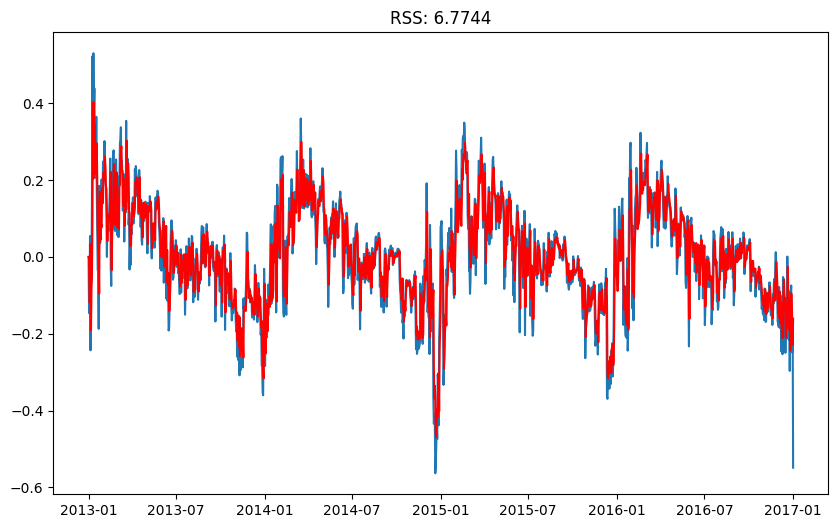

In [112]:
model_2 = ARIMA(datasetLogScaleMinusMovingExponentialDecayAverage, order=(4,1,3))
results_ARIMA = model_2.fit()
print(results_ARIMA.fittedvalues)
print('RSS: %f' % sum((results_ARIMA.fittedvalues-datasetLogScaleMinusMovingExponentialDecayAverage['meantemp'])**2))
plt.plot(datasetLogScaleMinusMovingExponentialDecayAverage)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_ARIMA.fittedvalues-datasetLogScaleMinusMovingExponentialDecayAverage['meantemp'])**2))
print("Plotting ARIMA Model")